## BiLSTM Model Architecture

I will define a Bidirectional Long Short-Term Memory (BiLSTM) model using Keras. The model will be designed to handle different input feature sizes, making it adaptable to Word2Vec, BoW, or TF-IDF features. The architecture will include:

1.  **Input Layer**: Flexible input shape based on the feature set.
2.  **Embedding Layer (Conditional)**: If using Word2Vec, an embedding layer might not be explicitly needed if pre-computed embeddings are directly used as features. For BoW/TF-IDF, a simple dense layer or direct input is suitable.
3.  **Bidirectional LSTM Layer**: To capture sequential dependencies in both forward and backward directions.
4.  **Dense Layers**: For classification, with a final sigmoid activation for binary classification.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

def create_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(input_shape, 1)), # Input needs to be 3D (batch, timesteps, features)
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("BiLSTM model definition function 'create_bilstm_model' created.")

BiLSTM model definition function 'create_bilstm_model' created.


In [2]:
# Install gensim library
!pip install gensim
print("gensim library installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 77.8 MB/s eta 0:00:00
gensim library installed.


The `df_combined_lemmatized_feature_engineered.csv` and the feature extractors (`CountVectorizer`, `TfidfVectorizer`, `Word2Vec` model) are already saved during feature engineering. This section will load these components directly, bypassing the redundant feature engineering steps.

In [3]:
import pandas as pd
import joblib
from gensim.models import Word2Vec

# Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the feature-engineered DataFrame
df_combined_lemmatized_feature_engineered = pd.read_csv('/content/drive/My Drive/Human vs AI Generated Text Classification/df_combined_lemmatized_feature_engineered.csv')
print("Loaded 'df_combined_lemmatized_feature_engineered.csv'")

# Load the CountVectorizer
vectorizer_bow = joblib.load('/content/drive/My Drive/Human vs AI Generated Text Classification/count_vectorizer.joblib')
print("Loaded 'count_vectorizer.joblib'")

# Load the TfidfVectorizer
vectorizer_tfidf = joblib.load('/content/drive/My Drive/Human vs AI Generated Text Classification/tfidf_vectorizer.joblib')
print("Loaded 'tfidf_vectorizer.joblib'")

# Load the Word2Vec model
word2vec_model = Word2Vec.load('/content/drive/My Drive/Human vs AI Generated Text Classification/word2vec_model.bin')
print("Loaded 'word2vec_model.bin'")

display(df_combined_lemmatized_feature_engineered.head())

Mounted at /content/drive
Loaded 'df_combined_lemmatized_feature_engineered.csv'
Loaded 'count_vectorizer.joblib'
Loaded 'tfidf_vectorizer.joblib'
Loaded 'word2vec_model.bin'


,label,length_chars,length_words,punctuation_ratio,repetition_score,text,cleaned_text
0,0,126,22,0.031746,0.045455,"as someone who follow food , I believe privacy...","someone follow food , believe privacy concern ..."
1,1,141,19,0.014184,0.000000,analysis indicate that travel be associate wit...,analysis indicate travel associate privacy con...
2,0,112,17,0.026786,0.000000,I recently experience education in my day to d...,recently experience education day day life fin...
3,1,101,14,0.009901,0.000000,analysis indicate that sport be associate with...,analysis indicate sport associate cost vary gr...
4,0,78,14,0.025641,0.000000,"in my experience , finance often lead to user ...","experience , finance often lead user report mi..."


With the feature extractors and `df_combined_lemmatized_feature_engineered` loaded, I will now regenerate the `bow_features`, `tfidf_features`, and `word2vec_document_embeddings` to prepare them for model training. The `cleaned_text` column from the loaded DataFrame will be used as input.

In [4]:
import numpy as np

# Ensure 'cleaned_text' column is filled for vectorizers
df_combined_lemmatized_feature_engineered['cleaned_text'] = df_combined_lemmatized_feature_engineered['cleaned_text'].fillna('')

# Generate BoW features
bow_features = vectorizer_bow.transform(df_combined_lemmatized_feature_engineered['cleaned_text'])
print(f"Shape of BoW features: {bow_features.shape}")

# Generate TF-IDF features
tfidf_features = vectorizer_tfidf.transform(df_combined_lemmatized_feature_engineered['cleaned_text'])
print(f"Shape of TF-IDF features: {tfidf_features.shape}")

# Define and apply get_document_embedding to generate Word2Vec document embeddings
def get_document_embedding(text):
    if not isinstance(text, str) or not text.strip():
        return np.zeros(word2vec_model.vector_size) # Return a zero vector for empty/invalid text

    tokens = text.split() # Assuming text is already tokenized or space-separated words

    # Filter out words not in the vocabulary and get their vectors
    word_vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]

    if not word_vectors:
        return np.zeros(word2vec_model.vector_size) # Return a zero vector if no words are in vocab

    return np.mean(word_vectors, axis=0)

word2vec_document_embeddings = np.array(df_combined_lemmatized_feature_engineered['cleaned_text'].apply(get_document_embedding).tolist())
print(f"Shape of Word2Vec document embeddings: {word2vec_document_embeddings.shape}")


# Extract numerical features and target variable
numerical_features = df_combined_lemmatized_feature_engineered[['length_chars', 'length_words', 'punctuation_ratio', 'repetition_score']]
y = df_combined_lemmatized_feature_engineered['label']

print("Numerical features extracted and target variable defined.")

Shape of BoW features: (20877, 38038)
Shape of TF-IDF features: (20877, 38038)
Shape of Word2Vec document embeddings: (20877, 100)
Numerical features extracted and target variable defined.


In [5]:
X_bow_combined = np.hstack((numerical_features.to_numpy(), bow_features.toarray()))

print(f"Shape of X_bow_combined: {X_bow_combined.shape}")

Shape of X_bow_combined: (20877, 38042)


I will select the specified numerical columns from `df_combined_lemmatized_feature_engineered` to create the `numerical_features` DataFrame.



In [6]:
import numpy as np

numerical_features = df_combined_lemmatized_feature_engineered[['length_chars', 'length_words', 'punctuation_ratio', 'repetition_score']]

print("Numerical features extracted.")
print(numerical_features.head())

Numerical features extracted.
   length_chars  length_words  punctuation_ratio  repetition_score
0           126            22           0.031746          0.045455
1           141            19           0.014184          0.000000
2           112            17           0.026786          0.000000
3           101            14           0.009901          0.000000
4            78            14           0.025641          0.000000


The next step is to define the `get_document_embedding` function as specified in the instructions. This function will tokenize text, retrieve Word2Vec vectors for words, and compute a mean document embedding, handling missing words and empty texts.



In [7]:
def get_document_embedding(text):
    if not isinstance(text, str) or not text.strip():
        return np.zeros(word2vec_model.vector_size) # Return a zero vector for empty/invalid text

    tokens = text.split() # Assuming text is already tokenized or space-separated words

    # Filter out words not in the vocabulary and get their vectors
    word_vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]

    if not word_vectors:
        return np.zeros(word2vec_model.vector_size) # Return a zero vector if no words are in vocab

    return np.mean(word_vectors, axis=0)

print("get_document_embedding function defined.")

get_document_embedding function defined.


Now that the `get_document_embedding` function is defined, I will apply it to the `cleaned_text` column of the dataframe to generate Word2Vec embeddings for each document. The resulting embeddings will be stored in `word2vec_document_embeddings`.



In [8]:
word2vec_document_embeddings = np.array(df_combined_lemmatized_feature_engineered['cleaned_text'].apply(get_document_embedding).tolist())

print(f"Shape of Word2Vec document embeddings: {word2vec_document_embeddings.shape}")

Shape of Word2Vec document embeddings: (20877, 100)


The next step is to combine the `numerical_features` with the `bow_features` as specified in the instructions. I will use `np.hstack` for this operation after ensuring `bow_features` is in a dense format if it's sparse.



In [9]:
X_bow_combined = np.hstack((numerical_features.to_numpy(), bow_features.toarray()))

print(f"Shape of X_bow_combined: {X_bow_combined.shape}")

Shape of X_bow_combined: (20877, 38042)


I will now combine the `numerical_features` with the `tfidf_features` using a horizontal stack, similar to how `bow_features` were combined, and store the result in `X_tfidf_combined`.



In [10]:
X_tfidf_combined = np.hstack((numerical_features.to_numpy(), tfidf_features.toarray()))

print(f"Shape of X_tfidf_combined: {X_tfidf_combined.shape}")

Shape of X_tfidf_combined: (20877, 38042)


I will combine the `numerical_features` with the `word2vec_document_embeddings` using a horizontal stack operation and store the result in `X_word2vec_combined`.



In [11]:
import numpy as np

X_word2vec_combined = np.hstack((numerical_features.to_numpy(), word2vec_document_embeddings))

print(f"Shape of X_word2vec_combined: {X_word2vec_combined.shape}")

Shape of X_word2vec_combined: (20877, 104)


Now that all feature sets have been created, I will extract the 'label' column from the `df_combined_lemmatized_feature_engineered` DataFrame and assign it to a variable named `y` as the target variable.



In [12]:
y = df_combined_lemmatized_feature_engineered['label']

print(f"Shape of target variable y: {y.shape}")
print(y.head())

Shape of target variable y: (20877,)
0    0
1    1
2    0
3    1
4    0
Name: label, dtype: int64


The next step os splitting each combined feature set and the target variable into training and testing sets. This involves importing `train_test_split` and applying it to each feature combination (`X_bow_combined`, `X_tfidf_combined`, `X_word2vec_combined`) with the target `y`, using a consistent `test_size` and `random_state` for reproducibility.



In [13]:
from sklearn.model_selection import train_test_split

# Define a random state for reproducibility
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Split BoW + Numerical features
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow_combined, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"BoW Feature Set - X_train_bow shape: {X_train_bow.shape}, X_test_bow shape: {X_test_bow.shape}")

# Split TF-IDF + Numerical features
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf_combined, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"TF-IDF Feature Set - X_train_tfidf shape: {X_train_tfidf.shape}, X_test_tfidf shape: {X_test_tfidf.shape}")

# Split Word2Vec + Numerical features
X_train_word2vec, X_test_word2vec, _, _ = train_test_split(X_word2vec_combined, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"Word2Vec Feature Set - X_train_word2vec shape: {X_train_word2vec.shape}, X_test_word2vec shape: {X_test_word2vec.shape}")

print(f"Target variable shapes: y_train {y_train.shape}, y_test {y_test.shape}")

BoW Feature Set - X_train_bow shape: (16701, 38042), X_test_bow shape: (4176, 38042)
TF-IDF Feature Set - X_train_tfidf shape: (16701, 38042), X_test_tfidf shape: (4176, 38042)
Word2Vec Feature Set - X_train_word2vec shape: (16701, 104), X_test_word2vec shape: (4176, 104)
Target variable shapes: y_train (16701,), y_test (4176,)


The very large feature set (`X_train_bow` shape: (16701, 38042)) is the primary reason for the BiLSTM model taking a very long time to train. Each input to the LSTM layers contains 38,042 features, which leads to a huge number of trainable parameters in the Bidirectional LSTM layers and significantly increases computational complexity and training time. For high-dimensional and sparse representations such as Bag-of-Words and TF-IDF, traditional machine learning models like Logistic Regression or SVMs are generally more appropriate, or dimensionality reduction techniques such as PCA are applied before using deep learning models. However, performing PCA on more than 38,000 features is itself computationally expensive and time-consuming. Training an LSTM model with BoW and numerical features was estimated to take approximately 5 hours on an A100 GPU and around 12 hours on an L4 GPU. Due to these limitations, only the Word2Vec-based model was trained. |


**Train BiLSTM with word2vec + Numerical Features**

In [21]:
import numpy as np

# 1. Determine the number of features in X_train_word2vec
number_of_features_word2vec = X_train_word2vec.shape[1]

# 2. Reshape X_train_word2vec to a 3D array
X_train_word2vec_reshaped = X_train_word2vec.reshape(X_train_word2vec.shape[0], number_of_features_word2vec, 1)

print(f"Reshaped X_train_word2vec shape: {X_train_word2vec_reshaped.shape}")

# 3. Create an instance of the BiLSTM model
bilstm_model_word2vec = create_bilstm_model(input_shape=number_of_features_word2vec)

# Display model summary
bilstm_model_word2vec.summary()

# 4. Train the created BiLSTM model
print("\nTraining BiLSTM model with Word2Vec + Numerical features...")
bilstm_model_word2vec.fit(
    X_train_word2vec_reshaped,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2 # Using a small validation split for monitoring
)

print("BiLSTM model for Word2Vec + Numerical features trained and stored in 'bilstm_model_word2vec'.")

Reshaped X_train_word2vec shape: (16701, 104, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 104, 128)       │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 104, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,065 (297.13 KB)

 Trainable params: 76,065 (297.13 KB)

 Non-trainable params: 0 (0.00 B)


Training BiLSTM model with Word2Vec + Numerical features...
Epoch 1/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.6150 - loss: 0.6456 - val_accuracy: 0.8102 - val_loss: 0.4220
Epoch 2/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8130 - loss: 0.4186 - val_accuracy: 0.8387 - val_loss: 0.3534
Epoch 3/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8414 - loss: 0.3560 - val_accuracy: 0.8770 - val_loss: 0.2897
Epoch 4/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8605 - loss: 0.3237 - val_accuracy: 0.8719 - val_loss: 0.3148
Epoch 5/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8896 - loss: 0.2752 - val_accuracy: 0.8973 - val_loss: 0.2616
Epoch 6/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9047 - loss: 0.2464 - val_accuracy: 0.9000 - val_loss: 0.2646
Epoch 7/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9079 - loss: 0.2355 - val_accuracy: 0.9063 - val_loss: 0.2468
Epoch 8/100
418/418 ━━━━━━━━

In [22]:
import numpy as np

# 1. Determine the number of features in X_test_word2vec
number_of_features_word2vec_test = X_test_word2vec.shape[1]

# 2. Reshape X_test_word2vec to a 3D array
X_test_word2vec_reshaped = X_test_word2vec.reshape(X_test_word2vec.shape[0], number_of_features_word2vec_test, 1)

print(f"Reshaped X_test_word2vec shape: {X_test_word2vec_reshaped.shape}")

# 3. Evaluate the trained BiLSTM model on the test set
print("\nEvaluating BiLSTM model for Word2Vec + Numerical features...")
loss_word2vec, accuracy_word2vec = bilstm_model_word2vec.evaluate(X_test_word2vec_reshaped, y_test, verbose=1)

# 4. Print the obtained loss and accuracy
print(f"BiLSTM Word2Vec Test Loss: {loss_word2vec:.4f}")
print(f"BiLSTM Word2Vec Test Accuracy: {accuracy_word2vec:.4f}")

Reshaped X_test_word2vec shape: (4176, 104, 1)

Evaluating BiLSTM model for Word2Vec + Numerical features...
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9699 - loss: 0.1410
BiLSTM Word2Vec Test Loss: 0.1219
BiLSTM Word2Vec Test Accuracy: 0.9705


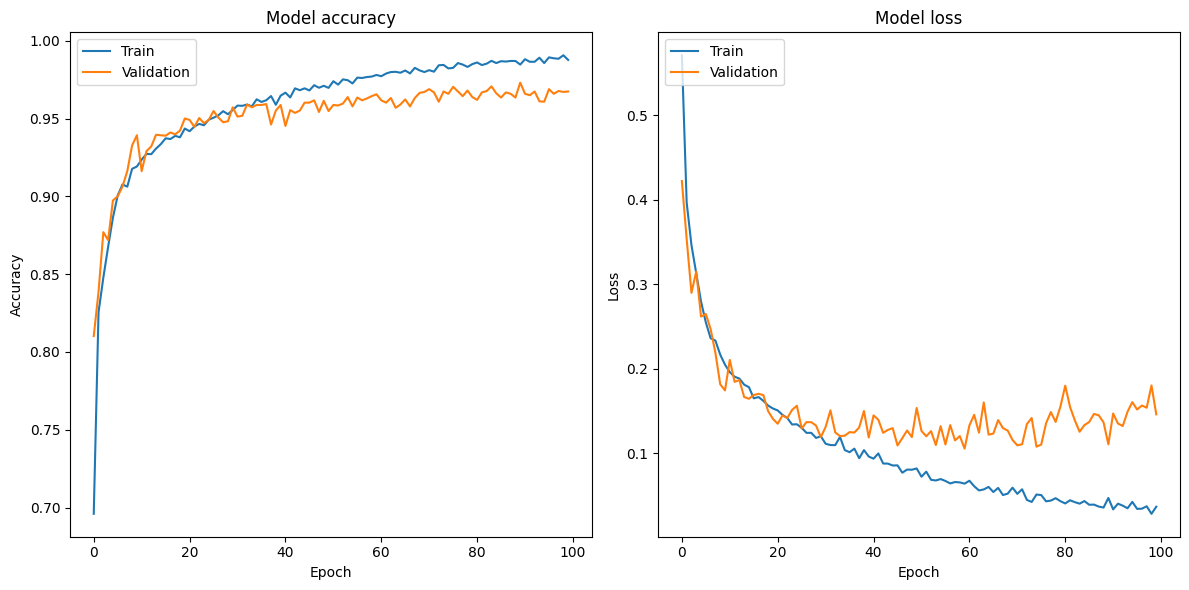

In [23]:
import matplotlib.pyplot as plt

history = bilstm_model_word2vec.history.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import roc_curve

# Predict probabilities on the test set
y_pred_proba_word2vec = bilstm_model_word2vec.predict(X_test_word2vec_reshaped)

# Calculate FPR, TPR, and thresholds
fpr_word2vec, tpr_word2vec, thresholds_word2vec = roc_curve(y_test, y_pred_proba_word2vec)

# Print the shapes of the calculated metrics
print(f"Shape of fpr_word2vec: {fpr_word2vec.shape}")
print(f"Shape of tpr_word2vec: {tpr_word2vec.shape}")
print(f"Shape of thresholds_word2vec: {thresholds_word2vec.shape}")

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Shape of fpr_word2vec: (319,)
Shape of tpr_word2vec: (319,)
Shape of thresholds_word2vec: (319,)


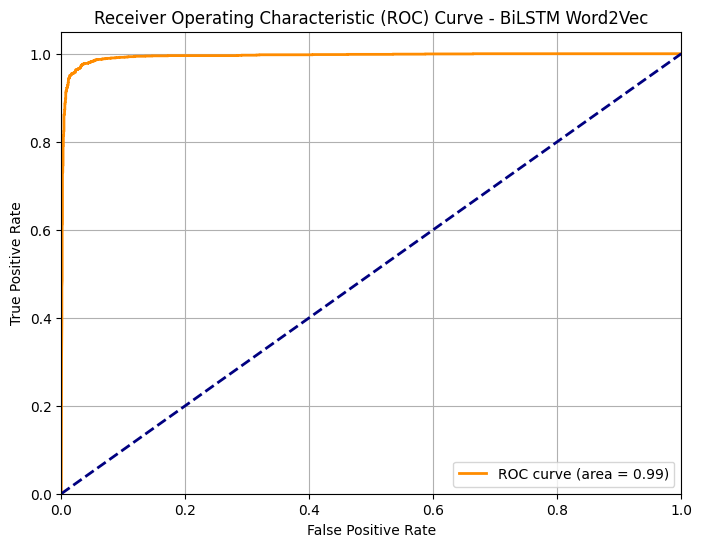

AUC for BiLSTM Word2Vec model: 0.9943


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Calculate AUC score
roc_auc_word2vec = auc(fpr_word2vec, tpr_word2vec)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_word2vec, tpr_word2vec, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_word2vec:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - BiLSTM Word2Vec')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC for BiLSTM Word2Vec model: {roc_auc_word2vec:.4f}")

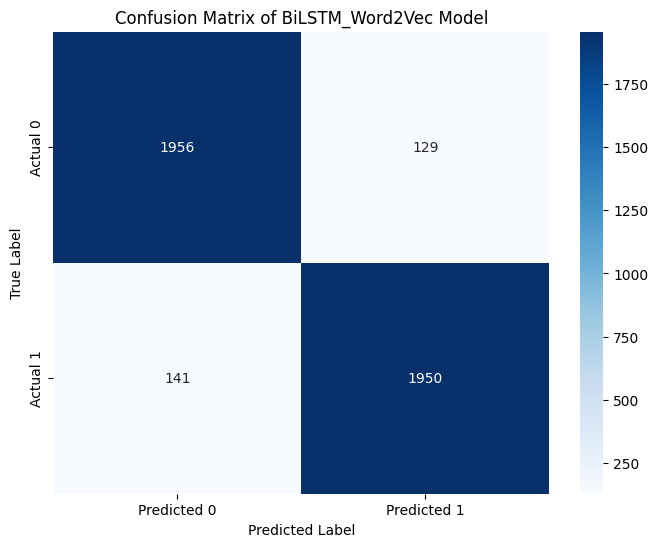

Confusion Matrix plot generated.


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_word2vec)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of BiLSTM_Word2Vec Model')
plt.show()

print("Confusion Matrix plot generated.")

In [26]:
import os

model_save_path = '/content/drive/My Drive/Human vs AI Generated Text Classification/bilstm_word2vec_model.keras'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
bilstm_model_word2vec.save(model_save_path)

print(f"BiLSTM Word2Vec model saved successfully to {model_save_path}")

BiLSTM Word2Vec model saved successfully to /content/drive/My Drive/Human vs AI Generated Text Classification/bilstm_word2vec_model.keras
